In [1]:
# %matplotlib ipympl
# %matplotlib notebook

# GRP Hopper

https://ieeexplore.ieee.org/document/7989248

## Simplified Version

In [2]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywu/Desktop/hopper_sim


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from models.GRP_hopper import simplified_GRP_hopper

# --- Load YAML configuration ---
with open("cfg/GRP_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)["simplified_GRP_hopper"]

# Unpack parameters
mb = cfg["mb"]
mf = cfg["mf"]
k = cfg["k"]
c = cfg["c"]
l0 = cfg["l0"]
g = cfg["g"]
substrate = cfg["substrate"]

x0 = np.array(cfg["x0"][0])
kp = cfg["controller"]["kp"]
kd = cfg["controller"]["kd"]

hopper = simplified_GRP_hopper(mb, mf, k, c, l0, g)

In [4]:
print(kp)
print(kd)

5000.0
12.0


### Two States State Machine

Initial state: flight


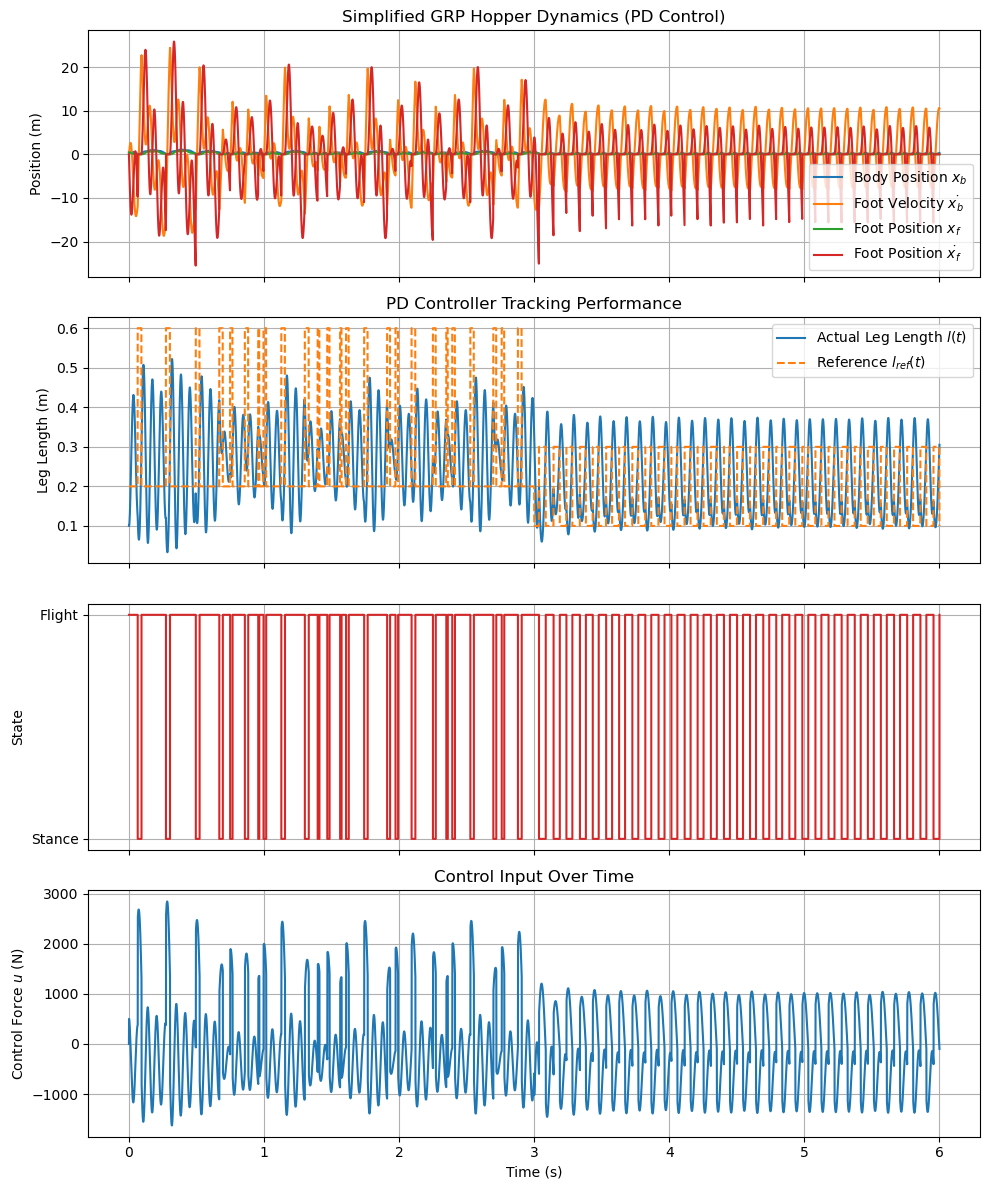

In [5]:
import numpy as np
import matplotlib.pyplot as plt

controller = hopper.PDController(kp=kp, kd=kd)

# --- Simulation setup ---
dt = 0.001
t_max = 6.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initialize state
x = np.zeros((steps, 4))
x[0] = x0

# control input history
u_hist = np.zeros(steps)

# Determine initial state (flight or stance)
state = "flight" if x0[2] > 0 else "stance"
print(f"Initial state: {state}")

# Store state (0 = stance, 1 = flight)
state_arr = np.zeros(steps)
state_arr[0] = 1 if state == "flight" else 0

# --- Main Simulation Loop ---
for i in range(1, steps):
    t_curr = t[i]

    # Controller target leg lengths
    if t_curr < 3.0:
        l_ref_flight = 0.2   # pull leg up more
        l_ref_stance = 0.6   # medium hop
    else:
        l_ref_flight = 0.1
        l_ref_stance = 0.3   

    # Select controller reference
    l_ref = l_ref_flight if state == "flight" else l_ref_stance
    ldot_ref = 0.0

    # Compute control force
    u = controller.compute(x[i-1], l_ref, ldot_ref)
    u_hist[i] = u  # record control input

    # --- Dynamics update ---
    if state == "flight":
        x_dot, F_sub = hopper.flight_state(x[i-1], u)
        x[i] = x[i-1] + x_dot * dt

        # touchdown condition
        if x[i-1][2] > 0 and x[i][2] <= 0 and x[i-1][3] < 0:
            x[i][2] = 0.0
            x[i][3] = 0.0
            state = "stance"

    elif state == "stance":
        x_dot, F_sub = hopper.stance_state(x[i-1], u, substrate)
        x[i] = x[i-1] + x_dot * dt

        # lift-off condition
        if F_sub <= 0 and x[i][1] > 0:
            state = "flight"

    # Record state (flight = 1, stance = 0)
    state_arr[i] = 1 if state == "flight" else 0

# ---------------------------------------------------------------------
# Visualization
# ---------------------------------------------------------------------
# Compute leg length and reference over time
l_actual = x[:, 0] - x[:, 2]
l_ref_traj = np.zeros_like(l_actual)

for i in range(steps):
    t_curr = t[i]
    if t_curr < 3.0:
        l_ref_traj[i] = 0.6 if state_arr[i] == 0 else 0.2  # stance / flight
    else:
        l_ref_traj[i] = 0.3 if state_arr[i] == 0 else 0.1

# --- Extended visualization ---
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1️⃣ Body and foot motion
axs[0].plot(t, x[:, 0], label='Body Position $x_b$')
axs[0].plot(t, x[:, 1], label='Foot Velocity $\dot{x_b}$')
axs[0].plot(t, x[:, 2], label='Foot Position $x_f$')
axs[0].plot(t, x[:, 3], label='Foot Position $\dot{x_f}$')
axs[0].set_ylabel('Position (m)')
axs[0].set_title('Simplified GRP Hopper Dynamics (PD Control)')
axs[0].legend()
axs[0].grid(True)

# 2️⃣ Leg length tracking
axs[1].plot(t, l_actual, label='Actual Leg Length $l(t)$', color='tab:blue')
axs[1].plot(t, l_ref_traj, '--', label='Reference $l_{ref}(t)$', color='tab:orange')
axs[1].set_ylabel('Leg Length (m)')
axs[1].set_title('PD Controller Tracking Performance')
axs[1].legend()
axs[1].grid(True)

# 3️⃣ State transitions
axs[2].plot(t, state_arr, color='tab:red', drawstyle='steps-post')
axs[2].set_ylabel('State')
axs[2].set_yticks([0, 1])
axs[2].set_yticklabels(['Stance', 'Flight'])
axs[2].grid(True)

# 4️⃣ Control input
axs[3].plot(t, u_hist, color='tab:blue')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Control Force $u$ (N)')
axs[3].set_title('Control Input Over Time')
axs[3].grid(True)

plt.tight_layout()
plt.show()



In [6]:
# # ======================================
# #  PyBullet visualization for GRP Hopper
# # ======================================
# import pybullet as p
# import pybullet_data
# import time
# import numpy as np

# # Assumes the following are already defined:
# #   x[:,0] = body position (x_b)
# #   x[:,2] = foot position (x_f)
# #   state_arr ∈ {0 (stance), 1 (flight)}
# #   t       = time array
# #   dt      = timestep

# # --- Initialize PyBullet ---
# p.connect(p.GUI)
# p.setAdditionalSearchPath(pybullet_data.getDataPath())
# p.setGravity(0, 0, -9.81)

# # Slightly lower plane so body never visually penetrates
# plane = p.loadURDF("plane.urdf", [0, 0, -0.02])

# # --- Visual parameters ---
# h_body = 0.05   # half height of body cube
# h_foot = 0.025  # half height of foot cube
# spring_color = [0, 1, 0]  # green spring visual

# # --- Create shapes ---
# body_visual = p.createVisualShape(
#     p.GEOM_BOX, halfExtents=[h_body, h_body, h_body], rgbaColor=[0, 0, 1, 1]
# )
# foot_visual = p.createVisualShape(
#     p.GEOM_BOX, halfExtents=[h_foot, h_foot, h_foot], rgbaColor=[1, 0.5, 0, 1]
# )
# body_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body])
# foot_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_foot, h_foot, h_foot])

# # --- Create rigid bodies (for visualization only) ---
# body = p.createMultiBody(
#     baseMass=1,
#     baseCollisionShapeIndex=body_col,
#     baseVisualShapeIndex=body_visual,
#     basePosition=[0, 0, x[0, 0] + h_body],
# )

# foot = p.createMultiBody(
#     baseMass=1,
#     baseCollisionShapeIndex=foot_col,
#     baseVisualShapeIndex=foot_visual,
#     basePosition=[0, 0, x[0, 2] + h_foot],
# )

# # --- Animation loop ---
# try:
#     print("Press Ctrl+C in terminal to stop simulation.")
#     start_time = time.time()

#     for i in range(len(t)):
#         # Current positions
#         z_body = x[i, 0]
#         z_foot = x[i, 2]
#         in_flight = state_arr[i] > 0.5

#         # Ground lock during stance
#         if not in_flight:
#             z_foot = 0.0

#         # Set new visual positions
#         p.resetBasePositionAndOrientation(body, [0, 0, z_body + h_body], [0, 0, 0, 1])
#         p.resetBasePositionAndOrientation(foot, [0, 0, z_foot + h_foot], [0, 0, 0, 1])

#         # Draw spring only during stance
#         p.removeAllUserDebugItems()
#         if not in_flight:
#             p.addUserDebugLine(
#                 [0, 0, z_foot + h_foot],
#                 [0, 0, z_body + h_body],
#                 spring_color,
#                 2,
#                 dt,
#             )

#         # Sync playback in real-time
#         target_time = start_time + t[i]
#         sleep_time = target_time - time.time()
#         if sleep_time > 0:
#             time.sleep(sleep_time)

# except KeyboardInterrupt:
#     print("\nAnimation stopped by user.")
# finally:
#     p.disconnect()


### NLP Controller for States Machine

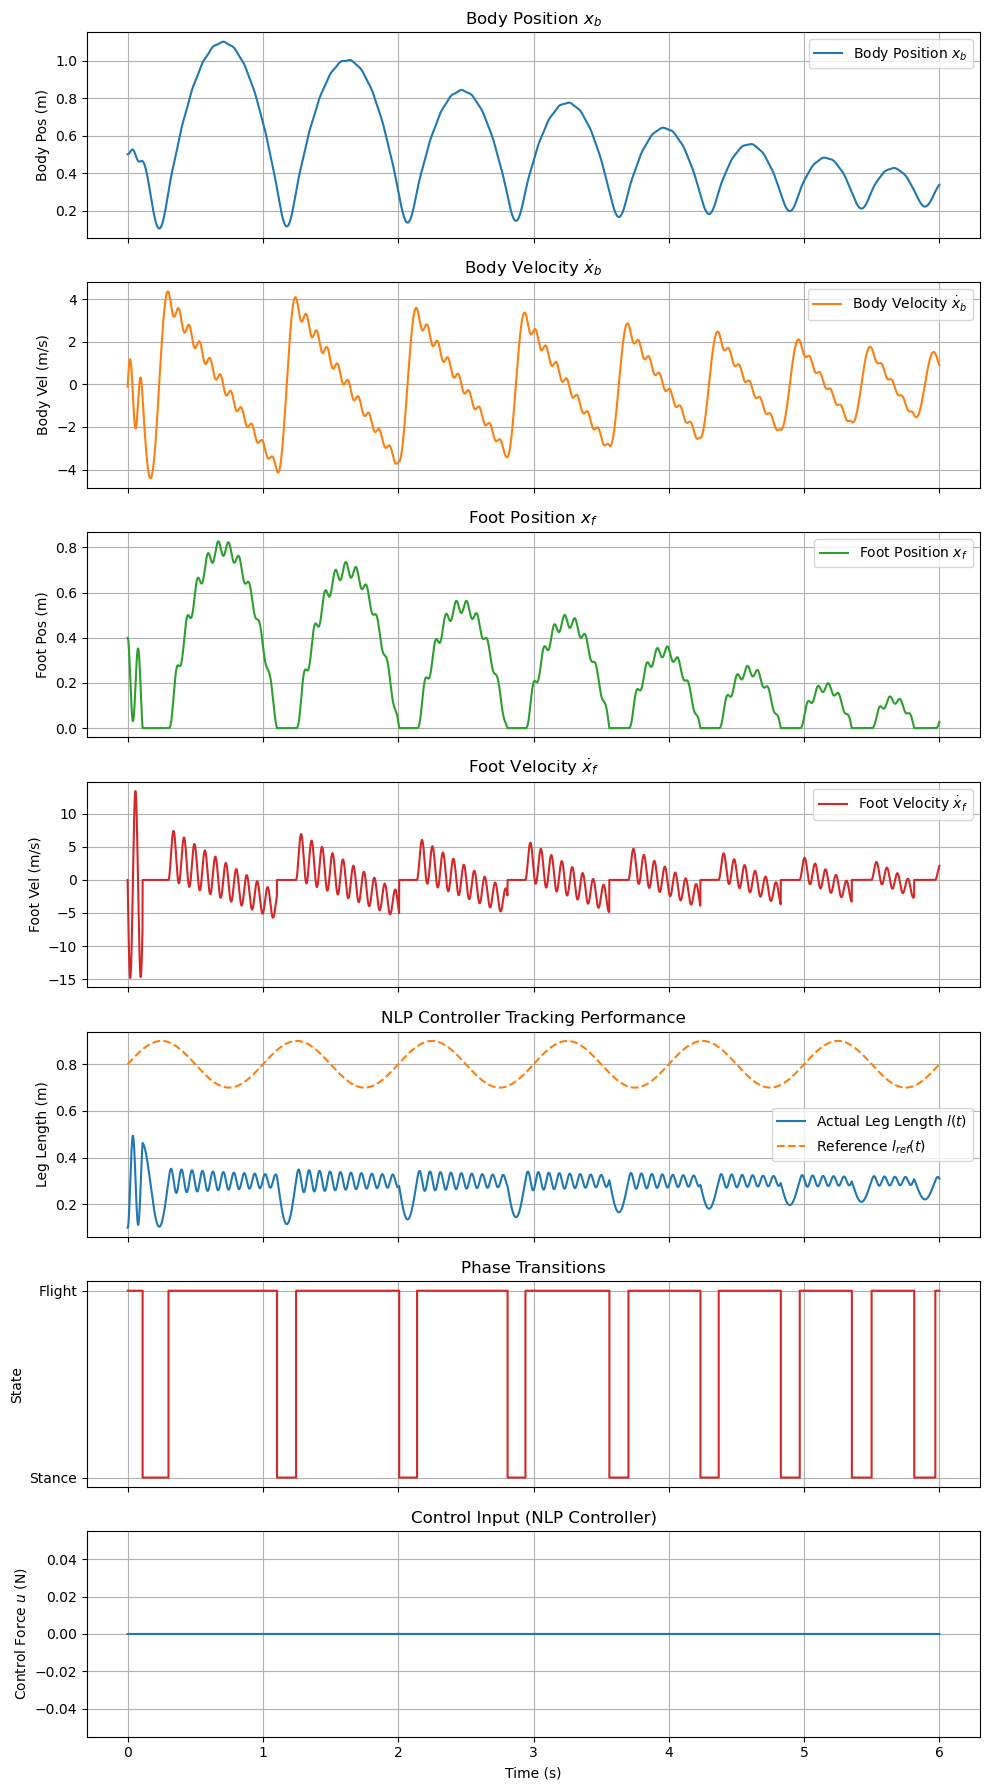

In [9]:
hopper = simplified_GRP_hopper(mb, mf, k, c, l0, g)
controller = simplified_GRP_hopper.NLPController(hopper, state='stance', horizon=8, dt=0.001)

import numpy as np
import matplotlib.pyplot as plt

# --- Simulation setup ---
dt = 0.001
t_max = 6.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

x = np.zeros((steps, 4))
x[0] = x0

u_hist = np.zeros(steps)
state_arr = np.zeros(steps)

# Initial phase
state = "flight" if x0[2] > 0 else "stance"
state_arr[0] = 1 if state == "flight" else 0

# Desired height trajectory
target_height = 0.8 + 0.1 * np.sin(2 * np.pi * 1.0 * t)  # small sinusoidal hopping pattern

for i in range(1, steps):
    controller.state = state
    u = controller.compute(x[i - 1], target_height[i])
    u_hist[i] = u

    # --- Dynamics update ---
    if state == "flight":
        x_dot, F_sub = hopper.flight_state(x[i - 1], u)
        x[i] = x[i - 1] + x_dot * dt

        if x[i - 1][2] > 0 and x[i][2] <= 0 and x[i - 1][3] < 0:
            x[i][2] = 0.0
            x[i][3] = 0.0
            state = "stance"

    elif state == "stance":
        x_dot, F_sub = hopper.stance_state(x[i - 1], u, substrate)
        x[i] = x[i - 1] + x_dot * dt

        if F_sub <= 0 and x[i][1] > 0:
            state = "flight"

    state_arr[i] = 1 if state == "flight" else 0


# ---------------------------------------------------------------------
# Visualization
# ---------------------------------------------------------------------
l_actual = x[:, 0] - x[:, 2]
l_ref_traj = target_height

fig, axs = plt.subplots(7, 1, figsize=(10, 18), sharex=True)

# 1️⃣ Body position
axs[0].plot(t, x[:, 0], color='tab:blue', label='Body Position $x_b$')
axs[0].set_ylabel('Body Pos (m)')
axs[0].set_title('Body Position $x_b$')
axs[0].legend()
axs[0].grid(True)

# 2️⃣ Body velocity
axs[1].plot(t, x[:, 1], color='tab:orange', label='Body Velocity $\dot{x}_b$')
axs[1].set_ylabel('Body Vel (m/s)')
axs[1].set_title('Body Velocity $\dot{x}_b$')
axs[1].legend()
axs[1].grid(True)

# 3️⃣ Foot position
axs[2].plot(t, x[:, 2], color='tab:green', label='Foot Position $x_f$')
axs[2].set_ylabel('Foot Pos (m)')
axs[2].set_title('Foot Position $x_f$')
axs[2].legend()
axs[2].grid(True)

# 4️⃣ Foot velocity
axs[3].plot(t, x[:, 3], color='tab:red', label='Foot Velocity $\dot{x}_f$')
axs[3].set_ylabel('Foot Vel (m/s)')
axs[3].set_title('Foot Velocity $\dot{x}_f$')
axs[3].legend()
axs[3].grid(True)

# 5️⃣ Leg length tracking performance
axs[4].plot(t, l_actual, label='Actual Leg Length $l(t)$', color='tab:blue')
axs[4].plot(t, l_ref_traj, '--', label='Reference $l_{ref}(t)$', color='tab:orange')
axs[4].set_ylabel('Leg Length (m)')
axs[4].set_title('NLP Controller Tracking Performance')
axs[4].legend()
axs[4].grid(True)

# 6️⃣ State transitions
axs[5].plot(t, state_arr, color='tab:red', drawstyle='steps-post')
axs[5].set_ylabel('State')
axs[5].set_yticks([0, 1])
axs[5].set_yticklabels(['Stance', 'Flight'])
axs[5].set_title('Phase Transitions')
axs[5].grid(True)

# 7️⃣ Control input
axs[6].plot(t, u_hist, color='tab:blue')
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Control Force $u$ (N)')
axs[6].set_title('Control Input (NLP Controller)')
axs[6].grid(True)

plt.tight_layout()
plt.show()


#### Visualize in PyPlot

In [8]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np

# # --- Set up figure ---
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.1, np.max(x[:, 0]) + 0.3)
# ax.set_xlabel("Horizontal position (m)")
# ax.set_ylabel("Vertical position (m)")
# ax.set_title("Simplified GRP Hopper Animation")

# # Elements: body (blue), leg (red), spring (green)
# body_dot, = ax.plot([], [], 'bo', markersize=10, label='Body')
# foot_dot, = ax.plot([], [], 'ro', markersize=6, label='Foot')
# spring_ln, = ax.plot([], [], 'g-', linewidth=3, label='Spring')
# ax.legend()
# ax.grid(True)

# # --- Initialization ---
# def init():
#     body_dot.set_data([], [])
#     foot_dot.set_data([], [])
#     spring_ln.set_data([], [])
#     return body_dot, foot_dot, spring_ln

# # --- Update frame ---
# def update(i):
#     x_b = x[i, 0]  # body height
#     x_f = x[i, 2]  # foot height
#     in_flight = state_arr[i] > 0.5

#     # In stance, the foot is on the ground
#     if not in_flight:
#         x_f = 0.0
#         spring_ln.set_data([0, 0], [x_f, x_b])
#     else:
#         spring_ln.set_data([], [])

#     body_dot.set_data([0], [x_b])
#     foot_dot.set_data([0], [x_f])
#     return body_dot, foot_dot, spring_ln

# # --- Create animation ---
# ani = animation.FuncAnimation(
#     fig,
#     update,
#     frames=len(t),
#     init_func=init,
#     blit=True,
#     interval=max(dt * 1000, 10),
#     repeat=True
# )

# plt.show()